### Практическая работа к занятию №2

Используем набор примеров fashion-MNIST

1.  Опишите - какой результата получен в нейросети в зависимости от:
  -  числа нейронов в слое(для 2-хслойной сети), 
  - числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров).
  - фиксируйте для тренировочного и тестового набора метрики accuracy.
2.  Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.Фиксируйте для тренировочного и тестового набора метрики accuracy.

3. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе? 

4. Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность). Сделайте вывод.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from keras.datasets import fashion_mnist

In [2]:
!nvidia-smi

Sun Feb 13 17:39:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Загрузка и предобратка данных

In [3]:
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


Взглянем с чем имеем дело

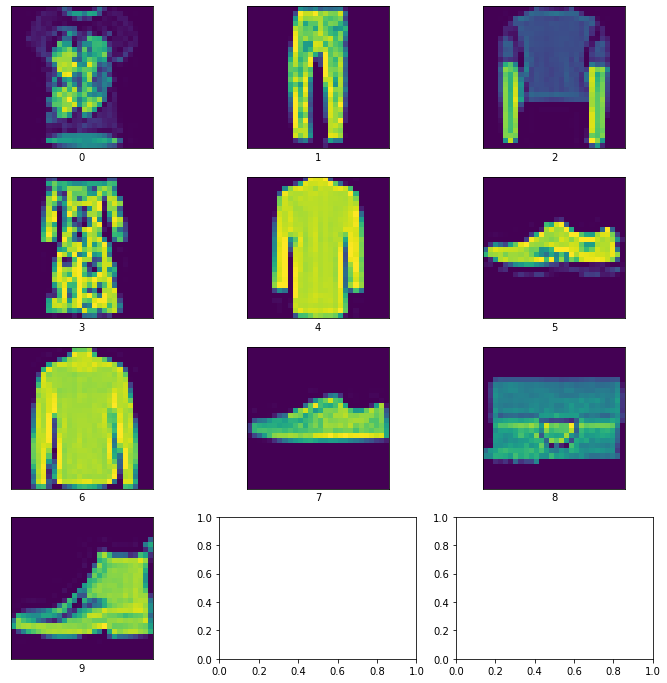

In [4]:
uniq_labels = np.unique(y_train)

fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

for label, ax in zip(uniq_labels, axes):
    idx = np.random.choice(list(np.where(y_train == label)[0]), 1)
    ax.imshow(X_train[idx].squeeze())
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    ax.set_xlabel(label)

plt.show()

In [5]:
# Нормализация изображений
X_train = (X_train / 127) - 1
X_test = (X_test / 127) - 1

# Векторизация
vector_size = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((-1, vector_size))
X_test = X_test.reshape((-1, vector_size))

# OHE for labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


#### Изменение числа нейронов для 2-хслойной сети

Processing model with 100 neurons...
Processing model with 200 neurons...
Processing model with 300 neurons...
Processing model with 400 neurons...
Processing model with 500 neurons...


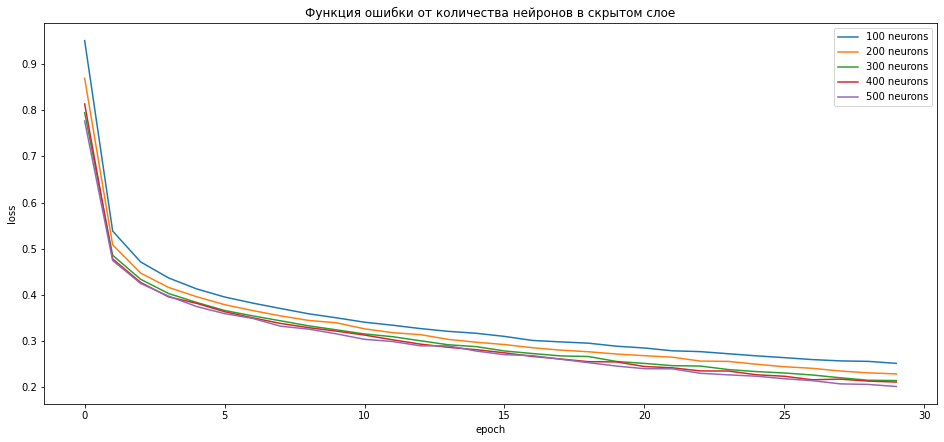

In [30]:
def create_model(neurons):
    model = Sequential([
        Dense(neurons, activation='tanh', input_shape=(vector_size,)),
        Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_model(model, epochs=30, batch_size=2048):
    train_logs = model.fit( 
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0,
        verbose=0
    )
    test_logs = model.evaluate(
        X_test,
        y_test,
        verbose=0
    )
    return train_logs, test_logs


grid_neurons = [100, 200, 300, 400, 500]
results = {}
plt.figure(figsize=(16,7))

for neurons in grid_neurons:
    print(f'Processing model with {neurons} neurons...')
    model = create_model(neurons)
    train_logs, test_logs = train_model(model)

    results[neurons] = {
        'acc_train': train_logs.history['accuracy'][-1],
        'acc_test': test_logs[1]
    }
    loss_train = train_logs.history['loss']

    plt.plot(np.arange(len(loss_train)), loss_train, label=f"{neurons} neurons")

plt.legend()
plt.title('Функция ошибки от количества нейронов в скрытом слое')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [31]:
pd.DataFrame.from_dict(results, orient='index').sort_values(by='acc_test', ascending=False)

,acc_train,acc_test
500,0.928900,0.8867
300,0.924383,0.8865
400,0.925967,0.8846
200,0.918933,0.8832
100,0.911500,0.8785


Получили вполне логичные результаты.
При увеличении количества нейронов в единственном скрытом слое получаем улучшение по accuracy. Функция ошибки также уменьшается быстрее.

#### Изменение числа слоев в модели (2, 3, 5, 10) при близких размерах сети по числу тренируемых параметров

Вручную были подобраны количества нейронов на входном слое и на скрытых. Процесс подбора за кадром. В среднем получается, что каждая модель имеет 350 тысяч обучаемых параметров

In [100]:
num_layers_list = [10, 5, 3, 2]
input_neurons_list = [200, 270, 340, 440]
hidden_neurons_list = [150, 200, 250, 0]

def create_model(num_layers, input_neurons, hidden_neurons, optimizer, verbose=False):
    model = Sequential(name=f'{num_layers}_layers')
    model.add(Dense(input_neurons, activation='tanh', input_shape=(vector_size,)))
    for k in range(num_layers - 2):
        model.add(Dense(hidden_neurons, activation='tanh'))
    model.add(Dense(10, activation='softmax'))
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    if verbose:
        print(f"Модель с {num_layers} слоями")
        print(f"Число обучаемых параметров: {model.count_params()}")
    return model

Модель с 10 слоями
Число обучаемых параметров: 347210
Модель с 5 слоями
Число обучаемых параметров: 348560
Модель с 3 слоями
Число обучаемых параметров: 354660
Модель с 2 слоями
Число обучаемых параметров: 349810


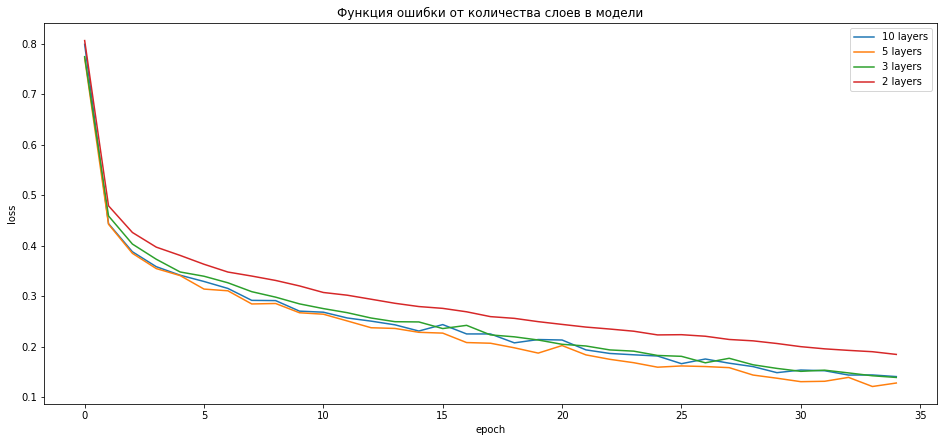

In [101]:
results = {}
plt.figure(figsize=(16,7))

for config in zip(num_layers_list, input_neurons_list, hidden_neurons_list):
    num_layers, input_neurons, hidden_neurons = config

    model = create_model(num_layers, input_neurons, hidden_neurons, 
                         optimizer='adam', verbose=True)
    train_logs, test_logs = train_model(model, epochs=35)

    results[num_layers] = {
        'acc_train': train_logs.history['accuracy'][-1],
        'acc_test': test_logs[1]
    }
    loss_train = train_logs.history['loss']

    plt.plot(np.arange(len(loss_train)), loss_train, label=f"{num_layers} layers")

plt.legend()
plt.title('Функция ошибки от количества слоев в модели')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [102]:
pd.DataFrame.from_dict(results, orient='index').sort_values(by='acc_test', ascending=False)

,acc_train,acc_test
2,0.936100,0.8871
10,0.947900,0.8862
5,0.952617,0.8845
3,0.950867,0.8844


Все модели показали одинаково хорошие результаты, но стоит заметить, что модель с 2 слоями меньше переобучилась.<br>
Можно предположить, что мы получаем такой результат, потому что задача слишком проста, и даже 2 слоев хватает для ее решения.

#### Тестировании различных оптимизаторов

Протестируем различные оптимизаторы (SGD, Adam, RMSProp) на лучшей модели - Модель с 2 слоями. 

Processing model with SGD optimizer
Processing model with RMSProp optimizer
Processing model with adam optimizer
Processing model with NAdam optimizer


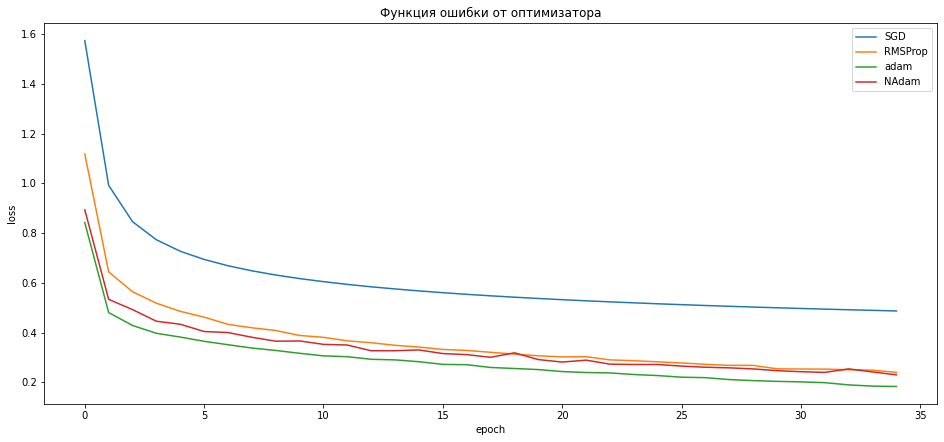

In [105]:
optimizers = ['SGD', 'RMSProp', 'adam', 'NAdam']
results = {}
plt.figure(figsize=(16,7))

for optimizer in optimizers:
    print(f"Processing model with {optimizer} optimizer")
    
    model = create_model(2, 440, 0, optimizer, verbose=False)
    train_logs, test_logs = train_model(model, epochs=35)

    results[optimizer] = {
        'acc_train': train_logs.history['accuracy'][-1],
        'acc_test': test_logs[1]
    }
    loss_train = train_logs.history['loss']

    plt.plot(np.arange(len(loss_train)), loss_train, label=f"{optimizer}")

plt.legend()
plt.title('Функция ошибки от оптимизатора')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [106]:
pd.DataFrame.from_dict(results, orient='index').sort_values(by='acc_test', ascending=False)

,acc_train,acc_test
adam,0.937467,0.8854
NAdam,0.917100,0.8760
RMSProp,0.909833,0.8572
SGD,0.832983,0.8180


Модель с оптимизатором Adam показала наилучший результат

#### Confusion matrix лучшей модели

Еще раз обучим самую лучшую модель по итогам 3 исследований

In [115]:
model = create_model(2, 440, 0, optimizer='adam', verbose=False)
train_logs, test_logs = train_model(model, epochs=35)

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred = np.argmax(train_pred, axis=1)
test_pred = np.argmax(test_pred, axis=1)

# reverse OHE
train_true = np.argmax(y_train, axis=1)
test_true = np.argmax(y_test, axis=1)

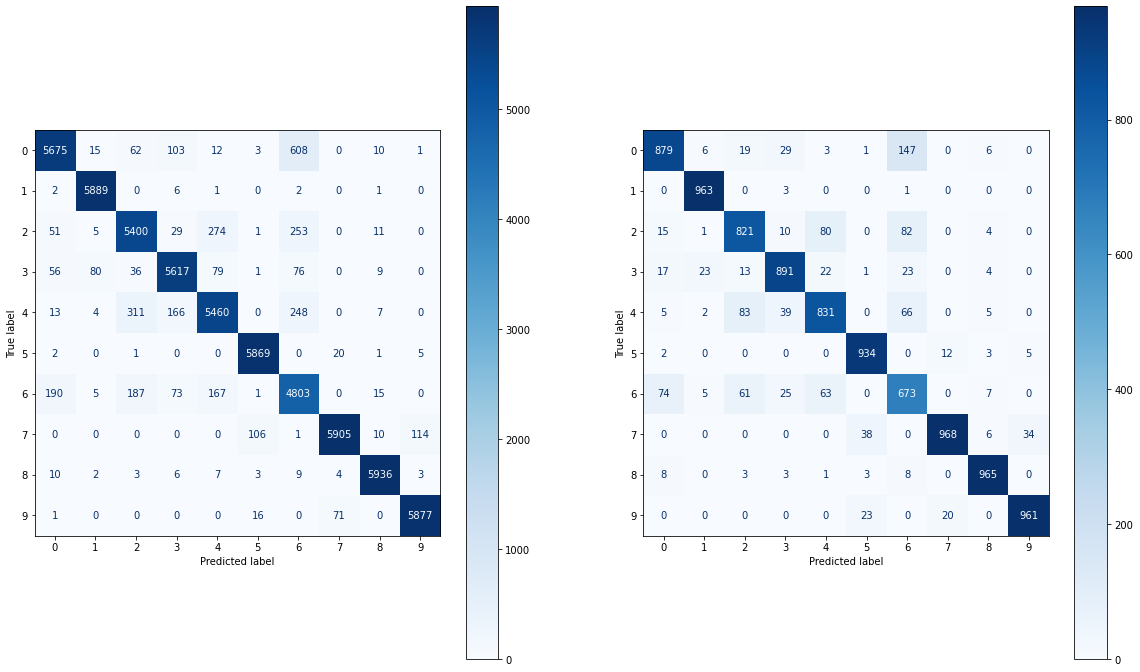

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

cm_train = confusion_matrix(train_pred, train_true)
cm_train_display = ConfusionMatrixDisplay(cm_train).plot(ax=ax1, cmap='Blues')

cm_test = confusion_matrix(test_pred, test_true)
cm_test_display = ConfusionMatrixDisplay(cm_test).plot(ax=ax2, cmap='Blues')

plt.show()

In [123]:
from sklearn.metrics import classification_report

print('#' * 25, 'TRAIN', '#' * 25)
print(classification_report(train_true, train_pred))
print('#' * 25, 'TEST', '#' * 25)
print(classification_report(test_true, test_pred))

######################### TRAIN #########################
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6000
           1       1.00      0.98      0.99      6000
           2       0.90      0.90      0.90      6000
           3       0.94      0.94      0.94      6000
           4       0.88      0.91      0.89      6000
           5       1.00      0.98      0.99      6000
           6       0.88      0.80      0.84      6000
           7       0.96      0.98      0.97      6000
           8       0.99      0.99      0.99      6000
           9       0.99      0.98      0.98      6000

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000

######################### TEST #########################
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1000
           1     

Хуже всего модель распознает классы 6, 4, 2, 0.
По матрице ошибок мы видим, что модель путает эти классы между собой.
Скорей всего это происходит, потому что эти 4 класса - это своего рода футболки либо с коротким рукавом, либо с длинным.